# Initializing

Importing Files from Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')   # To access gdrive files

Mounted at /content/drive


Download necessary libraries

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Import the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from gensim.models import Word2Vec

from nltk import sent_tokenize, word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Initializing Dataset

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/TokopediaCleanedStemmedFIXED.csv')

Dataset Information

In [5]:
def check_dataset_information():
  print('Total reviews: ' + str(len(dataset)))
  print('Dataset Columns: ')
  for columns in  dataset.columns:
    print('- ' + columns)
  print('Number of NULL dataset: ')
  print(str(dataset.isnull().sum()))
  print(dataset['Sentiment'].value_counts())

In [6]:
check_dataset_information()

Total reviews: 5400
Dataset Columns: 
- Unnamed: 0
- Unnamed: 0.1
- Review
- Sentiment
Number of NULL dataset: 
Unnamed: 0      0
Unnamed: 0.1    0
Review          0
Sentiment       0
dtype: int64
Negative    2820
Positive    2580
Name: Sentiment, dtype: int64


Removing Unnecessary Columns

In [7]:
useless_columns = ['Unnamed: 0', 'Unnamed: 0.1']
dataset = dataset.drop(useless_columns, 1)
check_dataset_information()

Total reviews: 5400
Dataset Columns: 
- Review
- Sentiment
Number of NULL dataset: 
Review       0
Sentiment    0
dtype: int64
Negative    2820
Positive    2580
Name: Sentiment, dtype: int64


# Creating the corpus

In [8]:
total_words = []

for sentence in dataset['Review']:
  temp = [] 
  tokenized = word_tokenize(sentence)   # Splits the review into individual words

  for word in tokenized:
    temp.append(word)                   # Turns it into an array

  total_words.append(temp)              # Turns it into a 2D array

# Word2Vec - CBOW


In [9]:
cbow_model = Word2Vec(total_words, min_count=1, size=200, sg=0) # sg = 0 => CBOW

In [10]:
print(cbow_model)

Word2Vec(vocab=6034, size=200, alpha=0.025)


In [11]:
cbow_model.wv.get_vector("barang")

array([ 0.27101126,  0.33902657,  0.3515071 ,  0.24596286, -0.03073958,
       -0.06918799, -0.32009724, -0.38781333, -0.09851182, -0.3565419 ,
       -0.14764042,  0.23412608,  0.11833547,  0.08483721, -0.03132285,
       -0.05353836,  0.25326398, -0.02576289, -0.41783488, -0.11595163,
        0.265397  , -0.43478882,  0.5132547 , -0.19834363, -0.14367345,
        0.10111279, -0.07304954, -0.03530989,  0.1214283 , -0.2013152 ,
        0.11480301,  0.06908395,  0.05565493, -0.0252299 ,  0.17398003,
        0.17880055,  0.2074535 ,  0.13918583, -0.03530077,  0.33865678,
        0.2021485 ,  0.04005962, -0.339783  , -0.08329713,  0.16701186,
       -0.33555838,  0.21778895, -0.17987758,  0.01662042, -0.05330983,
       -0.04503904,  0.13774699,  0.28141746, -0.06073493, -0.07158051,
        0.16568597, -0.1264956 , -0.168994  ,  0.5175913 ,  0.26296273,
        0.20190951,  0.2964898 ,  0.1265137 ,  0.22842619,  0.09460569,
       -0.28357807, -0.31809065, -0.2741977 , -0.19366328, -0.45

In [12]:
cbow_model.wv.most_similar("barang")

[('banget', 0.9999599456787109),
 ('mantap', 0.9999522566795349),
 ('sayang', 0.9999514222145081),
 ('kayak', 0.9999502301216125),
 ('pas', 0.9999495148658752),
 ('foto', 0.9999493360519409),
 ('coba', 0.9999489784240723),
 ('order', 0.9999489188194275),
 ('fungsi', 0.9999488592147827),
 ('main', 0.9999486804008484)]

Getting the average weight of each review

In [13]:
dataset['CBOW_Vector'] = ''     # Creating a new column for the vector of the sentence

for i, sentence in enumerate(total_words):
  result_cbow = np.mean(cbow_model[sentence], axis=0)   # Getting the average weight of every word in the sentence

  dataset.at[i, 'CBOW_Vector'] = result_cbow

dataset.head(3)

,Review,Sentiment,CBOW_Vector
0,alhamdulillah fungsi packaging aman respon cep...,Positive,"[0.24412672, 0.3053858, 0.31725416, 0.22196841..."
1,bagus respon cepat harga saing,Positive,"[0.24338767, 0.30671293, 0.31690058, 0.2235398..."
2,bagus fungsi seler ramah kirim cepat,Positive,"[0.26488748, 0.33392945, 0.34541798, 0.2415915..."


Reshaping the data

In [14]:
y_cbow = dataset['Sentiment']

x_cbow = dataset['CBOW_Vector'].to_numpy()
print(x_cbow.shape)

(5400,)


In [15]:
x_cbow[0]

array([ 0.24412672,  0.3053858 ,  0.31725416,  0.22196841, -0.02502161,
       -0.06391252, -0.29065245, -0.3460092 , -0.0883064 , -0.3247029 ,
       -0.13656065,  0.21277264,  0.10323755,  0.07656057, -0.02826563,
       -0.05038274,  0.2284135 , -0.02012217, -0.37516576, -0.10501304,
        0.23730452, -0.39058903,  0.462112  , -0.1753143 , -0.12826315,
        0.09320396, -0.06193719, -0.02947778,  0.11163343, -0.18284681,
        0.10034982,  0.0639276 ,  0.04986231, -0.02073587,  0.15404797,
        0.1588476 ,  0.18548094,  0.12767255, -0.03069908,  0.30317718,
        0.18052682,  0.03868086, -0.3083296 , -0.07944362,  0.15127316,
       -0.3003574 ,  0.1926479 , -0.16326475,  0.01505643, -0.0440663 ,
       -0.04160564,  0.1285009 ,  0.25368547, -0.05321915, -0.06316257,
        0.15257405, -0.11029851, -0.14997986,  0.46783328,  0.23909602,
        0.18898398,  0.26835996,  0.11073852,  0.20484884,  0.08805355,
       -0.25247163, -0.2910344 , -0.24717455, -0.17006016, -0.40

In [16]:
x_cbow = x_cbow.reshape(-1, 1)
print(x_cbow.shape)
x_cbow[0][0]

(5400, 1)


array([ 0.24412672,  0.3053858 ,  0.31725416,  0.22196841, -0.02502161,
       -0.06391252, -0.29065245, -0.3460092 , -0.0883064 , -0.3247029 ,
       -0.13656065,  0.21277264,  0.10323755,  0.07656057, -0.02826563,
       -0.05038274,  0.2284135 , -0.02012217, -0.37516576, -0.10501304,
        0.23730452, -0.39058903,  0.462112  , -0.1753143 , -0.12826315,
        0.09320396, -0.06193719, -0.02947778,  0.11163343, -0.18284681,
        0.10034982,  0.0639276 ,  0.04986231, -0.02073587,  0.15404797,
        0.1588476 ,  0.18548094,  0.12767255, -0.03069908,  0.30317718,
        0.18052682,  0.03868086, -0.3083296 , -0.07944362,  0.15127316,
       -0.3003574 ,  0.1926479 , -0.16326475,  0.01505643, -0.0440663 ,
       -0.04160564,  0.1285009 ,  0.25368547, -0.05321915, -0.06316257,
        0.15257405, -0.11029851, -0.14997986,  0.46783328,  0.23909602,
        0.18898398,  0.26835996,  0.11073852,  0.20484884,  0.08805355,
       -0.25247163, -0.2910344 , -0.24717455, -0.17006016, -0.40

In [17]:
x_cbow = np.concatenate(np.concatenate(x_cbow, axis=0), axis=0).reshape(-1, 200)
print(x_cbow.shape)

(5400, 200)


In [18]:
x_cbow[0][1]

0.3053858

In [19]:
print(x_cbow)

[[0.24412672 0.3053858  0.31725416 ... 0.11256937 0.32971036 0.31776458]
 [0.24338767 0.30671293 0.31690058 ... 0.11433335 0.32661885 0.31620485]
 [0.26488748 0.33392945 0.34541798 ... 0.1230514  0.35694623 0.34405628]
 ...
 [0.1473466  0.18569505 0.19117989 ... 0.06945168 0.19997051 0.19130784]
 [0.13780048 0.17202102 0.17639744 ... 0.06414778 0.18469064 0.1752944 ]
 [0.26770037 0.33690065 0.34833676 ... 0.12539597 0.36215228 0.34659508]]


Splitting the train and test

In [20]:
x_train_cbow, x_test_cbow, y_train_cbow, y_test_cbow = model_selection.train_test_split(x_cbow, y_cbow, test_size=0.2, random_state=100, stratify=y_cbow)

In [21]:
print('train shape = ' + str(x_train_cbow.shape))
print('train sentiment = ')
print(str(y_train_cbow.value_counts()))

print()

print('test shape = ' + str(x_test_cbow.shape))
print('test sentiment = ')
print(str(y_test_cbow.value_counts()))

train shape = (4320, 200)
train sentiment = 
Negative    2256
Positive    2064
Name: Sentiment, dtype: int64

test shape = (1080, 200)
test sentiment = 
Negative    564
Positive    516
Name: Sentiment, dtype: int64


## Logistic Regression

In [22]:
clf_cbow = LogisticRegression(random_state=0).fit(x_train_cbow, y_train_cbow)
clf_cbow.score(x_train_cbow, y_train_cbow)

0.6756944444444445

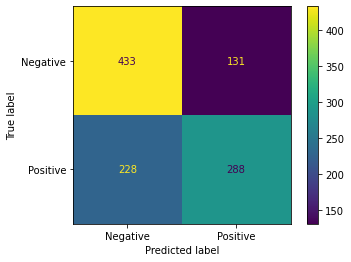

In [23]:
plot_confusion_matrix(clf_cbow, x_test_cbow, y_test_cbow)  
plt.show()

In [24]:
prediction_cbow = clf_cbow.predict(x_test_cbow)
print(classification_report(y_test_cbow, prediction_cbow))

              precision    recall  f1-score   support

    Negative       0.66      0.77      0.71       564
    Positive       0.69      0.56      0.62       516

    accuracy                           0.67      1080
   macro avg       0.67      0.66      0.66      1080
weighted avg       0.67      0.67      0.66      1080



### Fine Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_class_options = ['auto', 'ovr', 'multinomial']
class_weight_options = ['None', 'dict', 'balanced']
max_iter_options = [50, 100, 200]

param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options, max_iter = max_iter_options)

lr = LogisticRegression()             # initialize the model

grid = GridSearchCV(lr, param_grid, cv=12, scoring = 'accuracy', )

grid.fit(x_train_cbow, y_train_cbow)

In [26]:
print(grid.best_estimator_)

LogisticRegression(class_weight='balanced', max_iter=50,
                   multi_class='multinomial')


In [27]:
print(grid.best_score_)

0.7166666666666667


In [28]:
clf_cbow_FT = LogisticRegression(class_weight='balanced', max_iter=50, multi_class='multinomial', solver='newton-cg').fit(x_train_cbow, y_train_cbow)
clf_cbow_FT.score(x_train_cbow, y_train_cbow)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


0.7219907407407408

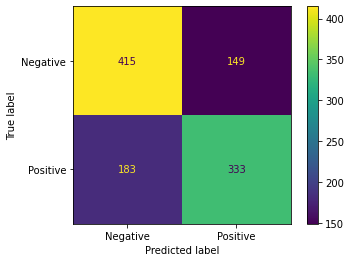

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_cbow_FT, x_test_cbow, y_test_cbow)  
plt.show()

In [30]:
new_prediction_cbow = clf_cbow_FT.predict(x_test_cbow)
print(classification_report(y_test_cbow, new_prediction_cbow))

              precision    recall  f1-score   support

    Negative       0.69      0.74      0.71       564
    Positive       0.69      0.65      0.67       516

    accuracy                           0.69      1080
   macro avg       0.69      0.69      0.69      1080
weighted avg       0.69      0.69      0.69      1080



## SVM - Support Vector Machine

In [31]:
svc_cbow = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
svc_cbow.fit(x_train_cbow, y_train_cbow)
svc_cbow.score(x_train_cbow, y_train_cbow)

0.8150462962962963

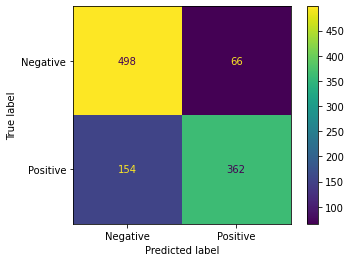

In [32]:
plot_confusion_matrix(svc_cbow, x_test_cbow, y_test_cbow)  
plt.show()

In [33]:
svc_cbow_prediction = svc_cbow.predict(x_test_cbow)
print(classification_report(y_test_cbow, svc_cbow_prediction))

              precision    recall  f1-score   support

    Negative       0.76      0.88      0.82       564
    Positive       0.85      0.70      0.77       516

    accuracy                           0.80      1080
   macro avg       0.80      0.79      0.79      1080
weighted avg       0.80      0.80      0.79      1080



# Word2Vec - Skip Gram

In [34]:
skip_model = Word2Vec(total_words, min_count=1, size=200, sg=1) # sg = 1 => Skip Gram

In [35]:
print(skip_model)

Word2Vec(vocab=6034, size=200, alpha=0.025)


In [36]:
skip_model.wv.most_similar("cepat")

[('ramah', 0.9955316185951233),
 ('fast', 0.9904720783233643),
 ('respon', 0.9876251220703125),
 ('top', 0.9872270822525024),
 ('aman', 0.9846023321151733),
 ('recommended', 0.9836846590042114),
 ('packaging', 0.9835966229438782),
 ('packing', 0.982522189617157),
 ('seller', 0.9822536706924438),
 ('pesan', 0.976434051990509)]

Getting the average weight of each review

In [37]:
dataset['Skip_Vector'] = ''     # Creating a new column for the vector of the sentence

for i, sentence in enumerate(total_words):
  result_skip = np.mean(skip_model[sentence], axis=0)   # Getting the average weight of every word in the sentence

  dataset.at[i, 'Skip_Vector'] = result_skip

dataset.head(3)

,Review,Sentiment,CBOW_Vector,Skip_Vector
0,alhamdulillah fungsi packaging aman respon cep...,Positive,"[0.24412672, 0.3053858, 0.31725416, 0.22196841...","[0.18981199, 0.1245604, 0.312941, 0.26716357, ..."
1,bagus respon cepat harga saing,Positive,"[0.24338767, 0.30671293, 0.31690058, 0.2235398...","[0.17300352, 0.12647057, 0.29801756, 0.2599778..."
2,bagus fungsi seler ramah kirim cepat,Positive,"[0.26488748, 0.33392945, 0.34541798, 0.2415915...","[0.1747336, 0.12399447, 0.28861442, 0.24650504..."


Reshaping the data

In [38]:
y_skip = dataset['Sentiment']

x_skip = dataset['Skip_Vector'].to_numpy()
x_skip = x_skip.reshape(-1, 1)
x_skip = np.concatenate(np.concatenate(x_skip, axis=0), axis=0).reshape(-1, 200)
x_skip.shape

(5400, 200)

In [39]:
print(x_skip)

[[ 0.18981199  0.1245604   0.312941   ... -0.01208848  0.22262302
   0.22244008]
 [ 0.17300352  0.12647057  0.29801756 ... -0.00518916  0.19281009
   0.21303567]
 [ 0.1747336   0.12399447  0.28861442 ... -0.0058835   0.19648576
   0.20410909]
 ...
 [ 0.17748313  0.1335701   0.21363546 ...  0.0175796   0.18358423
   0.15991686]
 [ 0.13579607  0.10868038  0.14261226 ...  0.02553705  0.12679917
   0.11407246]
 [ 0.18678714  0.13317144  0.26808748 ...  0.0041088   0.2048163
   0.19390972]]


Splitting the train and test

In [40]:
x_train_skip, x_test_skip, y_train_skip, y_test_skip = model_selection.train_test_split(x_skip, y_skip, test_size=0.2, random_state=100, stratify=y_skip)

In [41]:
print('train shape = ' + str(x_train_skip.shape))
print('train sentiment = ')
print(str(y_train_skip.value_counts()))

print()

print('test shape = ' + str(x_test_skip.shape))
print('test sentiment = ')
print(str(y_test_skip.value_counts()))

train shape = (4320, 200)
train sentiment = 
Negative    2256
Positive    2064
Name: Sentiment, dtype: int64

test shape = (1080, 200)
test sentiment = 
Negative    564
Positive    516
Name: Sentiment, dtype: int64


## Logistic Regression

In [42]:
clf_skip = LogisticRegression(random_state=0).fit(x_train_skip, y_train_skip)
clf_skip.score(x_train_skip, y_train_skip)

0.8152777777777778

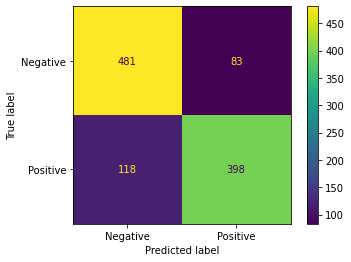

In [43]:
plot_confusion_matrix(clf_skip, x_test_skip, y_test_skip)  
plt.show()

In [44]:
prediction_skip = clf_skip.predict(x_test_skip)
print(classification_report(y_test_skip, prediction_skip))

              precision    recall  f1-score   support

    Negative       0.80      0.85      0.83       564
    Positive       0.83      0.77      0.80       516

    accuracy                           0.81      1080
   macro avg       0.82      0.81      0.81      1080
weighted avg       0.81      0.81      0.81      1080



## SVM - Support Vector Machine

In [45]:
svc_skip = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
svc_skip.fit(x_train_skip, y_train_skip)
svc_skip.score(x_train_skip, y_train_skip)

0.8511574074074074

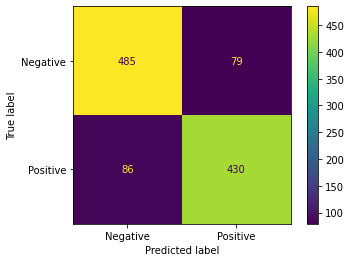

In [46]:
plot_confusion_matrix(svc_skip, x_test_skip, y_test_skip)  
plt.show()

In [47]:
svc_skip_prediction = svc_skip.predict(x_test_skip)
print(classification_report(y_test_skip, svc_skip_prediction))

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85       564
    Positive       0.84      0.83      0.84       516

    accuracy                           0.85      1080
   macro avg       0.85      0.85      0.85      1080
weighted avg       0.85      0.85      0.85      1080

